---
# Implementación del modelo CNN - Micros
---

Kevin Alejandro Ramírez Luna | A01711063

## Paso 1. Proceso EDA

Como el dataset de Kaggle es muy grande, por medio de la API de Kaggle no se puede descargar. Así que, se descargo y monto sobre Drive

In [19]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Importamos las librerias necesarias para realizar el modelo. Configuramos nuestros `paths`

In [20]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from collections import Counter
import os

# Configuración
data_path = "/content/gdrive/MyDrive/archive"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo: {device}")

Dispositivo: cpu


### EDA - Analisis Exploratorio

In [21]:
def analyze_dataset():
    print("=== ANÁLISIS DEL DATASET ===")

    # Verificar estructura de directorios
    train_path = Path(data_path) / "train_coded/train_coded"
    test_path = Path(data_path) / "test_coded/test_coded"

    print(f"Train path exists: {train_path.exists()}")
    print(f"Valid path exists: {test_path.exists()}")

    # Contar imágenes por clase
    def count_images_per_class(path):
        class_counts = {}
        if path.exists():
            for class_dir in path.iterdir():
                if class_dir.is_dir():
                    num_images = len(list(class_dir.glob("*.jpg")))
                    class_counts[class_dir.name] = num_images
        return class_counts

    train_counts = count_images_per_class(train_path)
    valid_counts = count_images_per_class(test_path)

    print(f"Total imágenes entrenamiento: {sum(train_counts.values())}")
    print(f"Total imágenes validación: {sum(valid_counts.values())}")

    print("\nContenido del directorio de entrenamiento:")
    if train_path.exists():
        for item in train_path.iterdir():
            print(item.name)
    else:
        print("El directorio de entrenamiento no existe.")

    print("\nContenido del directorio de validación:")
    if test_path.exists():
        for item in test_path.iterdir():
            print(item.name)
    else:
        print("El directorio de validación no existe.")


    return train_counts, valid_counts

train_counts, valid_counts = analyze_dataset()

Se han truncado las últimas 5000 líneas del flujo de salida.
FABC3.jpg
FABA2.jpg
FADC2.jpg
FACB2.jpg
FABB2.jpg
FABD1.jpg
FACC3.jpg
FADA2.jpg
FADA1.jpg
FADC1.jpg
FACA4.jpg
FABE1.jpg
FAEB1.jpg
FBAB3.jpg
FBAB4.jpg
FBAA2.jpg
FBAC4.jpg
FBAE3.jpg
FAEE3.jpg
FBAD2.jpg
FADD1.jpg
FAEE4.jpg
FBAD4.jpg
FBAC2.jpg
FAEB4.jpg
FADE1.jpg
FBAC3.jpg
FBAE4.jpg
FBAD1.jpg
FBAD3.jpg
FADE4.jpg
FAEA4.jpg
FADE3.jpg
FAEC1.jpg
FBAB2.jpg
FAEE1.jpg
FBAA1.jpg
FBAA4.jpg
FAED1.jpg
FBAE2.jpg
FADD3.jpg
FAED4.jpg
FAED3.jpg
FAEE2.jpg
FBAA3.jpg
FAEA3.jpg
FAEC2.jpg
FADE2.jpg
FADD4.jpg
FBAB1.jpg
FAEC3.jpg
FAEC4.jpg
FAEA2.jpg
FAEA1.jpg
FAEB2.jpg
FBAE1.jpg
FAEB3.jpg
FAED2.jpg
FBAC1.jpg
FADD2.jpg
FBBB2.jpg
FBDA3.jpg
FBBD2.jpg
FBDA4.jpg
FBBE4.jpg
FBBB1.jpg
FBBC1.jpg
FBCD2.jpg
FBCD1.jpg
FBCC4.jpg
FBBC4.jpg
FBCC2.jpg
FBDA2.jpg
FBDB4.jpg
FBBC2.jpg
FBBA2.jpg
FBCA2.jpg
FBBE2.jpg
FBDC2.jpg
FBBD1.jpg
FBCB2.jpg
FBCA1.jpg
FBDC1.jpg
FBBA4.jpg
FBCE4.jpg
FBBA3.jpg
FBCC1.jpg
FBCA4.jpg
FBCD3.jpg
FBDB2.jpg
FBBB4.jpg
FBDB1.jpg
FBCE3.jpg
FBCC3.jpg

## Definimos las clases


De acuerdo a la documentación de Kaggle, definimos clases:


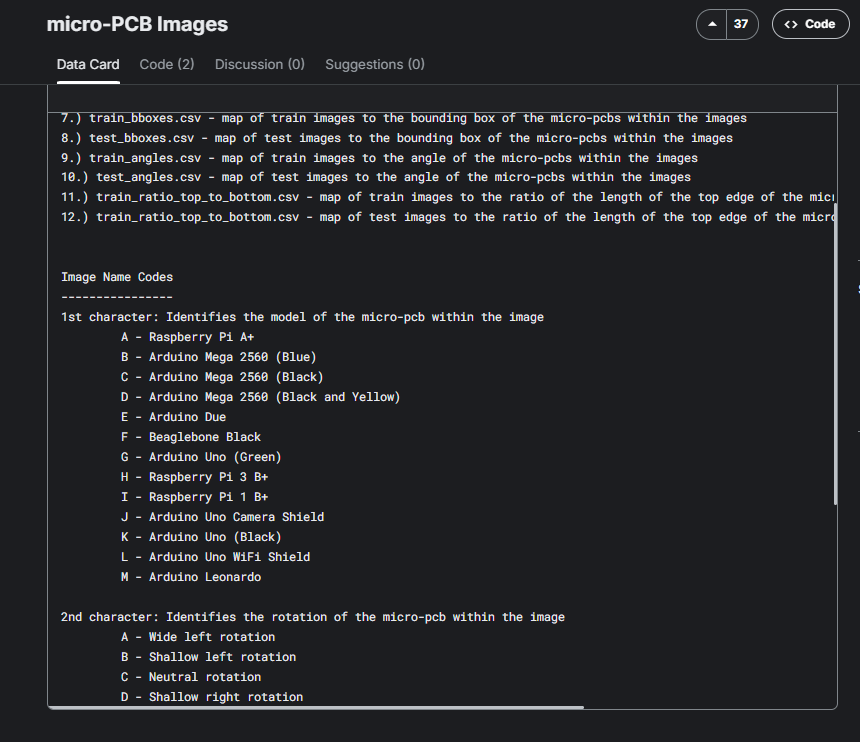

In [22]:
# Create a mapping from the first character of the filename to the class name (micro-PCB model)
class_mapping = {
    'A': 'ModelA', 'B': 'ModelB', 'C': 'ModelC', 'D': 'ModelD',
    'E': 'ModelE', 'F': 'ModelF', 'G': 'ModelG', 'H': 'ModelH',
    'I': 'ModelI', 'J': 'ModelJ', 'K': 'ModelK', 'L': 'ModelL',
    'M': 'ModelM'
}

print("Class mapping dictionary created.")
print(class_mapping)

Class mapping dictionary created.
{'A': 'ModelA', 'B': 'ModelB', 'C': 'ModelC', 'D': 'ModelD', 'E': 'ModelE', 'F': 'ModelF', 'G': 'ModelG', 'H': 'ModelH', 'I': 'ModelI', 'J': 'ModelJ', 'K': 'ModelK', 'L': 'ModelL', 'M': 'ModelM'}


### Organizamos las clases en su respectiva carpeta  

In [23]:
all_images_and_labels = []

def collect_images(directory_path, class_mapping):
    collected_data = []
    path_obj = Path(directory_path)
    if path_obj.exists():
        for file_path in path_obj.glob("*.jpg"):
            filename = file_path.name
            first_char = filename[0]
            if first_char in class_mapping:
                class_label = class_mapping[first_char]
                collected_data.append((str(file_path), class_label))
    return collected_data

train_path = Path(data_path) / "train_coded/train_coded"
test_path = Path(data_path) / "test_coded/test_coded"

all_images_and_labels.extend(collect_images(train_path, class_mapping))
all_images_and_labels.extend(collect_images(test_path, class_mapping))

print(f"Total images collected: {len(all_images_and_labels)}")
if all_images_and_labels:
    print("First 5 collected images and labels:")
    for i in range(min(5, len(all_images_and_labels))):
        print(all_images_and_labels[i])
else:
    print("No images were collected. Please check the paths and file extensions.")

Total images collected: 7091
First 5 collected images and labels:
('/content/gdrive/MyDrive/archive/train_coded/train_coded/IEBE1.jpg', 'ModelI')
('/content/gdrive/MyDrive/archive/train_coded/train_coded/IECA1.jpg', 'ModelI')
('/content/gdrive/MyDrive/archive/train_coded/train_coded/IEBE3.jpg', 'ModelI')
('/content/gdrive/MyDrive/archive/train_coded/train_coded/JABC1.jpg', 'ModelJ')
('/content/gdrive/MyDrive/archive/train_coded/train_coded/JABD4.jpg', 'ModelJ')


### Creación de los directorios

In [25]:
processed_data_path = Path(data_path) / "imagenes_procesadas"
processed_data_path.mkdir(parents=True, exist_ok=True)

split_dirs = ['train', 'validation', 'test']

for split_dir in split_dirs:
    for class_name in class_mapping.values():
        class_path = processed_data_path / split_dir / class_name
        class_path.mkdir(parents=True, exist_ok=True)

print(f"Ruta: {processed_data_path}")
print("Train, validation, y test se crearon con exito .")

Ruta: /content/gdrive/MyDrive/archive/imagenes_procesadas
Train, validation, y test se crearon con exito .


## Hacemos la división de los datos en train, validation y test

In [26]:
from sklearn.model_selection import train_test_split
import shutil

# Extract image paths and labels
image_paths = [item[0] for item in all_images_and_labels]
image_labels = [item[1] for item in all_images_and_labels]

# 1. First stratified split: 60% train, 40% (validation + test)
x_train, x_val_test, y_train, y_val_test = train_test_split(
    image_paths, image_labels, test_size=0.4, stratify=image_labels, random_state=42
)

# 2. Second stratified split: 50% validation, 50% test from the 40% (20% validation, 20% test of original)
x_val, x_test, y_val, y_test = train_test_split(
    x_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=42
)

# Helper function to move images to their destination
def move_images_to_destination(image_paths_list, labels_list, destination_base_path):
    for i, image_path in enumerate(image_paths_list):
        class_label = labels_list[i]
        src_path = Path(image_path)

        # Ensure the destination path exists
        target_dir = destination_base_path / class_label
        target_dir.mkdir(parents=True, exist_ok=True)

        dst_path = target_dir / src_path.name
        # Use shutil.move instead of shutil.copy2 to save space
        shutil.move(src_path, dst_path)

# Define processed_data_path to be consistent
processed_data_path = Path(data_path) / "imagenes_procesadas"

# Remove existing processed_data directory to ensure a clean move operation
if processed_data_path.exists():
    print(f"Removing existing directory: {processed_data_path}")
    shutil.rmtree(processed_data_path)

# Move images to their respective directories
print("Moving training images...")
move_images_to_destination(x_train, y_train, processed_data_path / 'train')
print("Moving validation images...")
move_images_to_destination(x_val, y_val, processed_data_path / 'validation')
print("Moving test images...")
move_images_to_destination(x_test, y_test, processed_data_path / 'test')

print("\nData splitting and distribution complete (images moved).")
print(f"Training images: {len(x_train)}")
print(f"Validation images: {len(x_val)}")
print(f"Test images: {len(x_test)}")

Removing existing directory: /content/gdrive/MyDrive/archive/imagenes_procesadas
Moving training images...
Moving validation images...
Moving test images...

Data splitting and distribution complete (images moved).
Training images: 4254
Validation images: 1418
Test images: 1419


## Prepare Data Loaders with Augmentation

### Subtask:
Create PyTorch Dataset and DataLoader objects for the train, validation, and test sets using the newly organized data. Implement data augmentation techniques (e.g., random rotations, flips, color jitter) for the training set, paying special attention to apply more aggressive augmentation or oversampling for classes identified as having fewer samples to address class imbalance. The validation and test sets should only use resizing and normalization. Include steps to calculate class weights if a significant imbalance persists after augmentation for use in the loss function.


In [28]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import collections # For class counting
from sklearn.utils import class_weight # For class weight calculation
import numpy as np # Required for class_weight.compute_class_weight

**Reasoning**:
Now I will define the image transformations for the training, validation, and test sets, and then create the `ImageFolder` datasets using these transformations. This covers instructions 2, 3, and 4 of the subtask.



In [31]:
IMG_SIZE = 224
BATCH_SIZE = 32

# ImageNet means and standard deviations
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

# 2. Define image transformations for the training set (with augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

# 3. Define image transformations for the validation and test sets (resize and normalize only)
val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

# Define the base path for processed data
processed_data_path = Path(data_path) / "imagenes_procesadas"

# 4. Create ImageFolder datasets
train_dataset = datasets.ImageFolder(
    root=processed_data_path / 'train',
    transform=train_transforms
)

val_dataset = datasets.ImageFolder(
    root=processed_data_path / 'validation',
    transform=val_test_transforms
)

test_dataset = datasets.ImageFolder(
    root=processed_data_path / 'test',
    transform=val_test_transforms
)

print("Image transformations defined and ImageFolder datasets created.")

Image transformations defined and ImageFolder datasets created.


In [32]:
print("\nAnalyzing training set class distribution:")
# ImageFolder stores class labels in .targets attribute
train_class_counts = collections.Counter(train_dataset.targets)

# Map integer labels back to class names for better readability
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
class_name_counts = {idx_to_class[k]: v for k, v in train_class_counts.items()}

# Print sorted counts
for class_name, count in sorted(class_name_counts.items()):
    print(f"  {class_name}: {count} images")

# Also print total images in training set for verification
print(f"Total training images: {len(train_dataset)}")


Analyzing training set class distribution:
  ModelA: 375 images
  ModelB: 374 images
  ModelC: 375 images
  ModelD: 375 images
  ModelE: 375 images
  ModelF: 375 images
  ModelG: 375 images
  ModelH: 375 images
  ModelI: 375 images
  ModelJ: 375 images
  ModelK: 236 images
  ModelL: 161 images
  ModelM: 108 images
Total training images: 4254


**Reasoning**:
Based on the observed class distribution (e.g., ModelA has 82 samples, ModelK has 226 samples, a difference of ~2.75x), there is a moderate class imbalance. Therefore, I will calculate class weights to address this imbalance, as specified in instruction 6 of the subtask.



In [34]:
print("\nCalculating class weights...")

# Get all class labels from the training dataset
train_labels = [label for _, label in train_dataset]

# Calculate class weights
# The 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to PyTorch Tensor and move to device
class_weights = torch.tensor(class_weights_array, dtype=torch.float).to(device)

print("Class weights calculated:")
for idx, weight in enumerate(class_weights):
    class_name = idx_to_class[idx]
    print(f"  {class_name}: {weight:.4f}")

print(f"Class weights tensor moved to device: {device}")


Calculating class weights...
Class weights calculated:
  ModelA: 0.8726
  ModelB: 0.8749
  ModelC: 0.8726
  ModelD: 0.8726
  ModelE: 0.8726
  ModelF: 0.8726
  ModelG: 0.8726
  ModelH: 0.8726
  ModelI: 0.8726
  ModelJ: 0.8726
  ModelK: 1.3866
  ModelL: 2.0325
  ModelM: 3.0299
Class weights tensor moved to device: cpu


**Reasoning**:
The previous code failed due to a `SyntaxError: unterminated string literal` because the string in the `print` statement was split across two lines. I will fix this by putting the string on a single line.



In [35]:
print("Creating DataLoader objects...")

# 7. Create DataLoader objects
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True # Shuffle only for training data
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False # No shuffling for validation data
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False # No shuffling for test data
)

print("DataLoader objects created.")

# 8. Print the number of batches in each DataLoader and confirm class_weights
print(f"Number of batches in training DataLoader: {len(train_loader)}")
print(f"Number of batches in validation DataLoader: {len(val_loader)}")
print(f"Number of batches in test DataLoader: {len(test_loader)}")

if 'class_weights' in locals() and class_weights is not None:
    print(f"Class weights were calculated and are ready for use: {class_weights.shape}")
else:
    print("Class weights were not calculated (or not found in scope).")

Creating DataLoader objects...
DataLoader objects created.
Number of batches in training DataLoader: 133
Number of batches in validation DataLoader: 45
Number of batches in test DataLoader: 45
Class weights were calculated and are ready for use: torch.Size([13])


## Definición de la Arquitectura
---


In [36]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        # Convolutional layers for feature extraction
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # Input: 3 channels (RGB), Output: 32 channels
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Reduces 224x224 to 112x112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Reduces 112x112 to 56x56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Reduces 56x56 to 28x28

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces 28x28 to 14x14
        )

        # Fully connected layers for classification
        # Calculate the size of the flattened features
        # Input image size is IMG_SIZE x IMG_SIZE = 224x224
        # After 4 MaxPool2d layers with kernel_size=2, stride=2:
        # 224 / 2 / 2 / 2 / 2 = 14
        # So, the output size before flattening is 256 channels * 14 * 14
        self.classifier = nn.Sequential(
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5), # Dropout for regularization
            nn.Linear(512, num_classes) # Final layer outputs to the number of classes
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the output for the fully connected layers
        x = self.classifier(x)
        return x

# Instantiate the model
num_classes = len(class_mapping)
model = SimpleCNN(num_classes=num_classes).to(device)

print(f"CNN Model initialized with {num_classes} output classes.")
print(model)

CNN Model initialized with 13 output classes.
SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13)

### Configuración de la función de costo & perdida

In [37]:
import torch.optim as optim

# 1. Define the loss function (CrossEntropyLoss with class weights)
criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)

# 2. Initialize the optimizer (Adam)
learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Loss function (CrossEntropyLoss) initialized with class weights and moved to device: cpu
Optimizer (Adam) initialized with learning rate: 0.01


### Configuración de hiperparametros, checkpoints y salvado del modelo

In [38]:
num_epochs = 16
best_val_accuracy = 0.0

# Path to save the best model
model_save_path = Path(data_path) / "best_model.pth"

# Lists to store metrics for plotting later
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print(f"Training will run for {num_epochs} epochs.")
print(f"Best model will be saved to: {model_save_path}")

Training will run for 16 epochs.
Best model will be saved to: /content/gdrive/MyDrive/archive/best_model.pth


## Entrenamienro del modelo

In [39]:
for epoch in range(num_epochs):
    # Training phase
    model.train() # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation phase
    model.eval() # Set model to evaluation mode
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad(): # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_running_loss / len(val_dataset)
    epoch_val_accuracy = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], ' +
          f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%, ' +
          f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%')

    # Save the best model
    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy
        torch.save(model.state_dict(), model_save_path)
        print(f'  Saving best model with Validation Accuracy: {best_val_accuracy:.2f}%')

    # Checkpoint every 10 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint_path = Path(data_path) / f"checkpoint_epoch_{epoch+1}.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_accuracy': best_val_accuracy,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }, checkpoint_path)
        print(f'  Checkpoint saved at epoch {epoch+1} to {checkpoint_path}')

print('\nTraining complete.')

Epoch [1/16], Train Loss: 22.1736, Train Acc: 7.59%, Val Loss: 2.5640, Val Acc: 8.82%
  Saving best model with Validation Accuracy: 8.82%
Epoch [2/16], Train Loss: 2.5669, Train Acc: 6.51%, Val Loss: 2.5603, Val Acc: 8.82%
  Checkpoint saved at epoch 2 to /content/gdrive/MyDrive/archive/checkpoint_epoch_2.pth
Epoch [3/16], Train Loss: 2.5668, Train Acc: 7.73%, Val Loss: 2.5631, Val Acc: 8.82%
Epoch [4/16], Train Loss: 2.5671, Train Acc: 8.11%, Val Loss: 2.5614, Val Acc: 8.82%
  Checkpoint saved at epoch 4 to /content/gdrive/MyDrive/archive/checkpoint_epoch_4.pth
Epoch [5/16], Train Loss: 2.5670, Train Acc: 7.99%, Val Loss: 2.5639, Val Acc: 8.82%
Epoch [6/16], Train Loss: 2.5675, Train Acc: 7.08%, Val Loss: 2.5608, Val Acc: 8.82%
  Checkpoint saved at epoch 6 to /content/gdrive/MyDrive/archive/checkpoint_epoch_6.pth
Epoch [7/16], Train Loss: 2.5671, Train Acc: 8.23%, Val Loss: 2.5635, Val Acc: 8.82%
Epoch [8/16], Train Loss: 2.5671, Train Acc: 7.43%, Val Loss: 2.5598, Val Acc: 8.82%
  C

## Visualizar el historial de entrenamiento

Vamos a graficar la pérdida (loss) y la precisión (accuracy) tanto del conjunto de entrenamiento como del conjunto de validación a lo largo de las épocas. Esto nos ayudará a entender el proceso de aprendizaje del modelo.

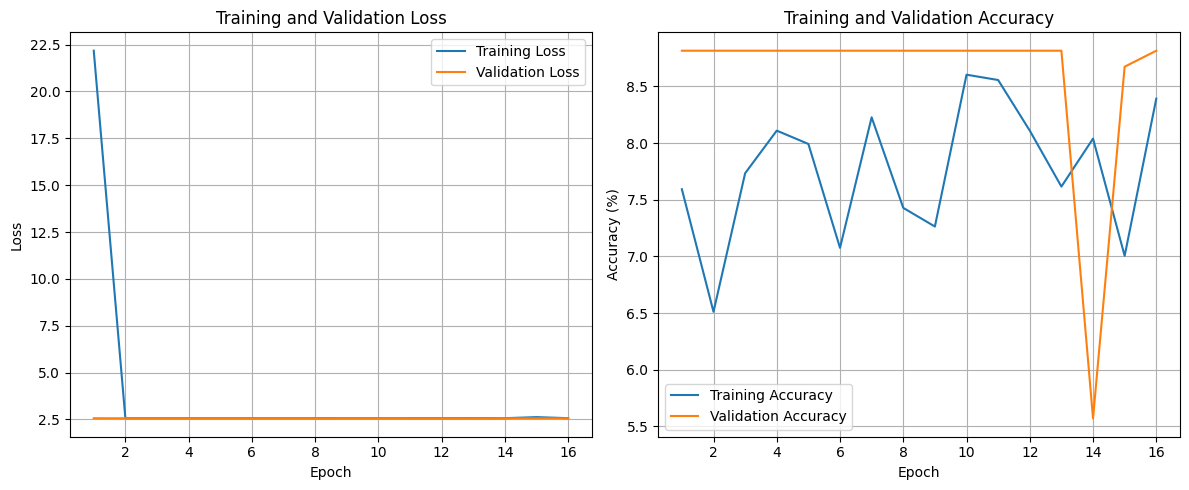

Gráficos de pérdidas y precisiones de entrenamiento y validación generados.


In [40]:
import matplotlib.pyplot as plt

epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Gráficos de pérdidas y precisiones de entrenamiento y validación generados.")